In [1]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q
!pip install opendatasets -q


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nayanitharushika
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification


100%|██████████| 217M/217M [00:03<00:00, 70.6MB/s]


In [4]:
BATCH_SIZE =32
IMAGE_SIZE=(128,128)

In [5]:
train_data_dir="/content/cats-and-dogs-for-classification/cats_dogs/train"
test_data_dir="/content/cats-and-dogs-for-classification/cats_dogs/test"

In [6]:
train_data=tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMAGE_SIZE,
                                                       subset='training',
                                                       validation_split=0.1,
                                                       seed=42)
validation_data=tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMAGE_SIZE,
                                                       subset='validation',
                                                       validation_split=0.1,
                                                       seed=42)
test_data=tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMAGE_SIZE)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [7]:
class_names=train_data.class_names
class_names

['cats', 'dogs']

In [8]:
for image_batch,label_batch in train_data.take(1):
  print(image_batch.shape)
  print(label_batch.shape)

(32, 128, 128, 3)
(32,)


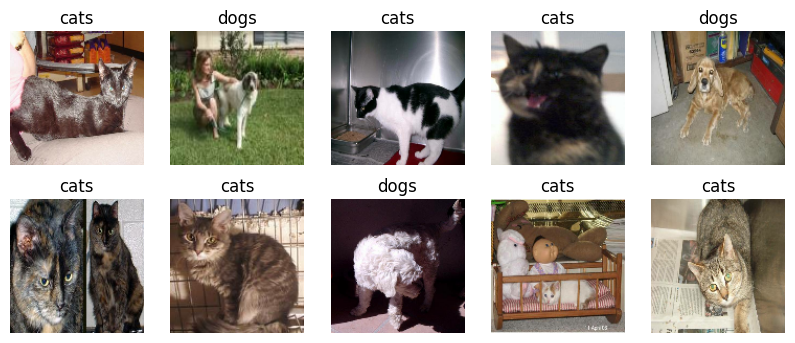

In [15]:
plt.figure(figsize=(10, 4))
for image, label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')



In [17]:
for image,label in train_data.take(1):
  for i in range(1):
    print(image)

tf.Tensor(
[[[[101.00769   104.00769   109.00769  ]
   [111.074585  112.71521   114.30505  ]
   [117.635284  115.31354   112.59396  ]
   ...
   [129.86246   132.91324   136.22964  ]
   [126.8725    133.10297   135.69281  ]
   [128.9002    138.99207   139.94614  ]]

  [[ 85.20029    88.20029    93.20029  ]
   [ 99.3725     99.79227   101.78906  ]
   [114.00287   112.997925  110.048706 ]
   ...
   [116.720825  120.720825  123.720825 ]
   [119.9389    126.16937   128.75922  ]
   [138.79547   147.0824    148.93893  ]]

  [[ 92.54297    94.90234    99.58203  ]
   [ 91.57605    91.986206   93.986206 ]
   [105.38388   104.38388   101.75107  ]
   ...
   [120.73743   125.52237   128.52237  ]
   [130.21445   135.21445   138.21445  ]
   [127.32648   134.36554   136.68585  ]]

  ...

  [[118.07504   122.07504   125.07504  ]
   [121.617584  125.617584  128.61758  ]
   [130.54602   134.54602   137.54602  ]
   ...
   [ 81.51825    87.02301    96.76108  ]
   [ 45.951294   50.819916   54.147003 ]
   [ 

In [18]:
train_data=train_data.map(lambda x,y:(x/255,y))
validation_data=validation_data.map(lambda x,y:(x/255,y))
test_data=test_data.map(lambda x,y:(x/255,y))

In [19]:
data_augmentation=tf.keras.Sequential(
    [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(128,128,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
    ]
)

In [21]:
model=tf.keras.models.Sequential()
model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128,kernel_size=3,activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

In [22]:
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())

In [23]:
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(32,activation='relu'))

model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)      

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [28]:
start_time=time.time()
history=model.fit(train_data,
                  epochs=20,
                  validation_data=validation_data)
end_time=time.time()

Epoch 1/20
225/225 [==============================] - 17s 37ms/step - loss: 0.6709 - accuracy: 0.5903 - val_loss: 0.6782 - val_accuracy: 0.5788
Epoch 2/20
225/225 [==============================] - 9s 40ms/step - loss: 0.6364 - accuracy: 0.6342 - val_loss: 0.6447 - val_accuracy: 0.5913
Epoch 3/20
225/225 [==============================] - 10s 42ms/step - loss: 0.6181 - accuracy: 0.6572 - val_loss: 0.8430 - val_accuracy: 0.5188
Epoch 4/20
225/225 [==============================] - 10s 44ms/step - loss: 0.5969 - accuracy: 0.6762 - val_loss: 0.6497 - val_accuracy: 0.6338
Epoch 5/20
225/225 [==============================] - 8s 35ms/step - loss: 0.5894 - accuracy: 0.6832 - val_loss: 0.5478 - val_accuracy: 0.7312
Epoch 6/20
225/225 [==============================] - 10s 42ms/step - loss: 0.5734 - accuracy: 0.6969 - val_loss: 0.4980 - val_accuracy: 0.7588
Epoch 7/20
225/225 [==============================] - 10s 45ms/step - loss: 0.5473 - accuracy: 0.7153 - val_loss: 0.6191 - val_accuracy: 0

In [29]:
history.history

{'loss': [0.6709259152412415,
  0.6363642811775208,
  0.618098258972168,
  0.5969297885894775,
  0.5894071459770203,
  0.5733547806739807,
  0.5472736358642578,
  0.5385629534721375,
  0.5220964550971985,
  0.5073679685592651,
  0.5112587213516235,
  0.49420735239982605,
  0.48012083768844604,
  0.47894805669784546,
  0.45385169982910156,
  0.44855859875679016,
  0.44530564546585083,
  0.43466702103614807,
  0.42877575755119324,
  0.42598918080329895],
 'accuracy': [0.5902777910232544,
  0.6341666579246521,
  0.6572222113609314,
  0.6762499809265137,
  0.6831944584846497,
  0.6969444155693054,
  0.7152777910232544,
  0.722777783870697,
  0.7436110973358154,
  0.7458333373069763,
  0.7468055486679077,
  0.7576388716697693,
  0.7686111330986023,
  0.7709722518920898,
  0.7831944227218628,
  0.7898610830307007,
  0.7888888716697693,
  0.7948611378669739,
  0.7933333516120911,
  0.8026388883590698],
 'val_loss': [0.6782237887382507,
  0.6446797251701355,
  0.843024730682373,
  0.6496887207

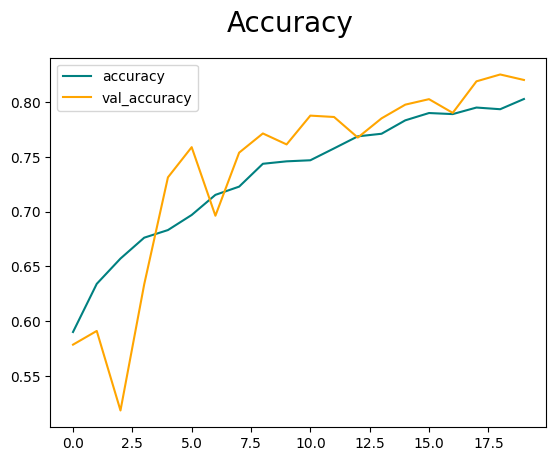

In [31]:
fig=plt.figure()
plt.plot(history.history['accuracy'],color='teal',label='accuracy')
plt.plot(history.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend()
plt.show()

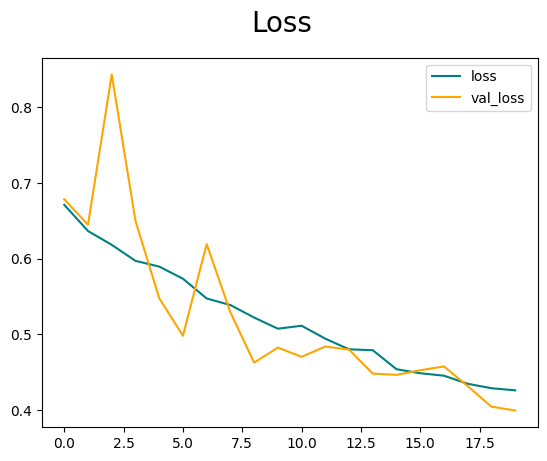

In [33]:
fig=plt.figure()
plt.plot(history.history['loss'],color='teal',label='loss')
plt.plot(history.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend()
plt.show()

In [34]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
accuracy=tf.keras.metrics.BinaryAccuracy()

In [35]:
for batch in test_data.as_numpy_iterator():
  x,y=batch
  yhat=model.predict(x)
  precision.update_state(y,yhat)
  recall.update_state(y,yhat)
  accuracy.update_state(y,yhat)

1/1 [==============================] - 0s 438ms/step


In [36]:
precision.result()
recall.result()
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.8195>

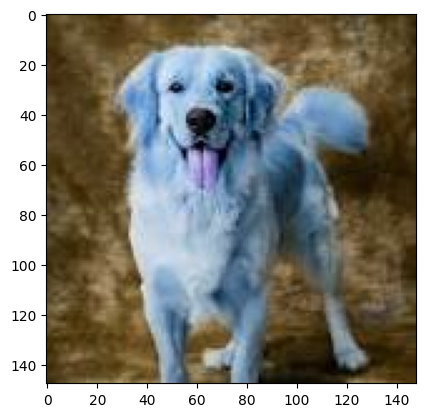

In [37]:
!pip install opencv.python
import cv2
image=cv2.imread("/content/download.jpeg")
plt.imshow(image)
plt.show()


In [41]:

resized_image=tf.image.resize(image,IMAGE_SIZE)
scaled_image=resized_image/255

In [42]:
scaled_image

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.2679295 , 0.1934197 , 0.05616479],
        [0.34373948, 0.26922965, 0.13197476],
        [0.3962594 , 0.32174957, 0.18449467],
        ...,
        [0.23583984, 0.1746266 , 0.05630553],
        [0.2409017 , 0.1781566 , 0.0644311 ],
        [0.25280523, 0.19006012, 0.07633463]],

       [[0.26743165, 0.19292183, 0.05566693],
        [0.33608878, 0.26157898, 0.12432407],
        [0.38656366, 0.31205386, 0.17479894],
        ...,
        [0.2488712 , 0.18765797, 0.0693369 ],
        [0.23891315, 0.17616804, 0.06244256],
        [0.23651099, 0.1737659 , 0.0600404 ]],

       [[0.26636893, 0.19185911, 0.05460421],
        [0.3196423 , 0.2451325 , 0.1078776 ],
        [0.36317402, 0.28866422, 0.15140931],
        ...,
        [0.27313304, 0.21191981, 0.09359873],
        [0.24457337, 0.18182828, 0.06810278],
        [0.21984433, 0.15709923, 0.04337374]],

       ...,

       [[0.2701507 , 0.20826344, 0.08124138],
        [0.28

In [43]:
np.expand_dims(scaled_image,0).shape

(1, 128, 128, 3)

In [44]:
y_hat=model.predict(np.expand_dims(scaled_image,0))
y_hat

1/1 [==============================] - 0s 500ms/step


array([[0.7934556]], dtype=float32)

In [45]:
class_names

['cats', 'dogs']

In [51]:
if y_hat > 0.5:
    print(class_names[1])
else:
    print(class_names[0])


dogs
